In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../RentHop" directory.

from subprocess import check_output
print(check_output(["ls", "../RentHop"]).decode("utf8"))

# Any results you write to the the current directory are saved as output.

RentHop.ipynb
test.json
train.json



In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import log_loss
from nltk import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import vincenty

In [6]:
df = pd.read_json(open("../RentHop/train.json","r"))

In [7]:
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [8]:
print(df.columns, len(df))

(Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object'), 49352)


In [9]:
df["created"] = pd.to_datetime(df["created"])
df["time_since_built"] = pd.datetime.today() - df["created"]
df["days_since_built"] = df["time_since_built"].astype('timedelta64[D]').astype(int)
df["len_descrip"] = df["description"].apply(lambda x: len(x.split(" ")))
df["len_features"] = df["features"].apply(len)
df["num_photos"] = df["photos"].apply(len)

In [10]:
all_descrip = list(df["description"])
all_descrip_words = ' '.join(all_descrip)
all_feat = []
all_feat.extend(df["features"])
# all_feat_sum = sum(all_feat,[]) this code works but is tooooo slow, the following code is way better, 10 times faster
all_feat_sum = [item.lower() for sublist in all_feat for item in sublist] # lowercase reduced freq from 1595 to 1294
print(len(all_descrip_words),len(all_feat_sum))

(29758052, 267906)


In [11]:
freq = FreqDist(all_feat_sum)
freq_df = pd.DataFrame(freq.most_common(len(freq)))
freq_df.columns = [['features','frequencies']]
freq_df.head()

,features,frequencies
0,elevator,26273
1,hardwood floors,23558
2,cats allowed,23540
3,dogs allowed,22035
4,doorman,20967


In [12]:
high_freq_feat = list(freq_df[:int(len(freq)/3)]["features"])
med_freq_feat = list(freq_df[int(len(freq)/3):int(len(freq)*2/3)]["features"])
low_freq_feat = list(freq_df[int(len(freq)*2/3):]["features"])
print(high_freq_feat[:10],med_freq_feat[:10],low_freq_feat[:10])

([u'elevator', u'hardwood floors', u'cats allowed', u'dogs allowed', u'doorman', u'dishwasher', u'laundry in building', u'no fee', u'fitness center', u'laundry in unit'], [u'garage attached', u'close to transit', u'foyer', u'stainless steel kitchen', u'extra closet space', u'huge room', u'queen size bedrooms', u'intercom', u'pets - case by case.', u'24/7 full-time doorman concierge'], [u'** w60s wonder ~ near the park! * overszed studio steal * courtyard * free gym * elev/lndry bldg * cats ok **', u"** oversized 2br super share * chef's kitchen * exposed brick * lndry bldg * heart of the village **", u'mullion pane windows', u'ceiling fan', u'floor-to-ceiling windows', u'outdoor space (private roof deck)', u"two en-suite balcony's.", u'updated appliances', u'** oversized & underpriced!! * sprawling sunfilled studio * gourmet kitchen * gut renovated * w50s ~ near central park! **', u'one month rent free concession on a 12 month lease'])


In [13]:
df["num_high_feat"] = df["features"].apply(lambda x: len([item for item in x if item.lower() in high_freq_feat]))
df["num_med_feat"] = df["features"].apply(lambda x: len([item for item in x if item.lower() in med_freq_feat]))
df["num_low_feat"] = df["features"].apply(lambda x: len([item for item in x if item.lower() in low_freq_feat]))

In [15]:
sns.barplot(x='features', y = 'frequencies', data = freq_df[:20])
plt.xticks(rotation=60, fontsize = 10)
plt.show()

In [16]:
bad_words = ['Pre-War','PreWar','Prewar','prewar','pre-war','pre war','Pre War']
df["num_badwords"] = df["features"].apply(lambda x: len([item for item in x if item in bad_words]))

In [17]:
stop = stopwords.words('english') + list(string.punctuation)
stop.extend(['br','br/','p','1','2','3','--',"''","'s"])
tokens = word_tokenize(all_descrip_words.lower())
clean_descrip = [i for i in tokens if i not in stop]
freq = FreqDist(clean_descrip)

In [18]:
n = 50
freq_des = pd.DataFrame(freq.most_common(n))
freq_des.columns = [['word','frequencies']]
freq_des.head()

,word,frequencies
0,apartment,39748
1,website_redacted,35409
2,building,32898
3,kitchen,29907
4,new,27178


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

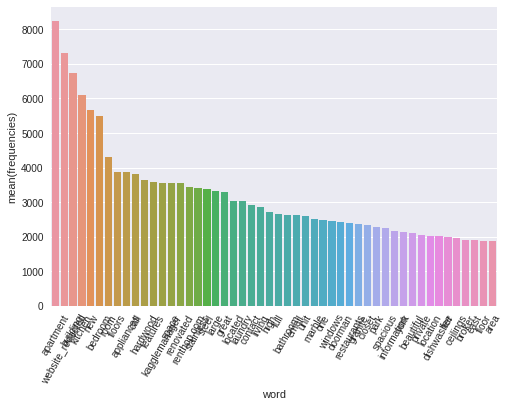

In [11]:
sns.barplot(x='word', y = 'frequencies', data = freq_des)
plt.xticks(rotation=60, fontsize = 10)

In [21]:
# set keywords according to the frequencies of all words
key_words = ['new','appliances','renovated','large','great','spacious','beautiful','beautifully','brand','close','top','excellent','recently','luxury','clean','nice','big','kitchen','amenity','safe']
df["num_keywords"] = df["description"].apply(lambda x: sum(x.count(i) for i in key_words))

In [22]:
# calculate the distance from time square and downtown world trade center
time_square = [40.7589, -73.9851]
world_trade_center = [40.7124, -74.0128]
df["location"] = list(zip(df["latitude"],df["longitude"]))
df["dist_ts"] = df["location"].apply(lambda x: vincenty(time_square, x).miles)
df["dist_wtc"] = df["location"].apply(lambda x: vincenty(world_trade_center, x).miles)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [24]:
num_feats = ["bedrooms",  "dist_wtc", "price",
             "num_photos", "len_descrip", "num_keywords", "num_high_feat","num_med_feat","num_low_feat",
             "days_since_built"] #remove "dist_ts",  "len_features", "bathrooms", "num_badwords",
#X = df[num_feats]
X = pd.DataFrame(scaler.fit_transform(df[num_feats]), columns=num_feats)
y = df["interest_level"]
X.head()

,bedrooms,dist_wtc,price,num_photos,len_descrip,num_keywords,num_high_feat,num_med_feat,num_low_feat,days_since_built
0,0.375,0.000680,0.000659,0.073529,0.141141,0.038462,0.000000,0.000000,0.0,0.067416
1,0.250,0.001141,0.001208,0.161765,0.012012,0.000000,0.131579,0.000000,0.0,0.202247
2,0.125,0.000349,0.000625,0.117647,0.139640,0.192308,0.078947,0.142857,0.0,0.831461
3,0.125,0.000684,0.000720,0.044118,0.118619,0.115385,0.052632,0.000000,0.0,0.820225
4,0.500,0.001554,0.000737,0.044118,0.100601,0.153846,0.026316,0.000000,0.0,0.707865


In [25]:
corrmat = X.corr()
sns.heatmap(corrmat, vmax=.8, square=True)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [28]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.6406574970322263

In [ ]:
df = pd.read_json(open("../RentHop/test.json", "r"))
df["created"] = pd.to_datetime(df["created"])
df["time_since_built"] = pd.datetime.today() - df["created"]
df["days_since_built"] = df["time_since_built"].astype('timedelta64[D]').astype(int)
df["len_descrip"] = df["description"].apply(lambda x: len(x.split(" ")))
df["len_features"] = df["features"].apply(len)
df["num_photos"] = df["photos"].apply(len)
df["num_keywords"] = df["description"].apply(lambda x: sum(x.count(i) for i in key_words))
df["num_badwords"] = df["features"].apply(lambda x: len([item for item in x if item in bad_words]))
df["num_high_feat"] = df["features"].apply(lambda x: len([item for item in x if item.lower() in high_freq_feat]))
df["num_med_feat"] = df["features"].apply(lambda x: len([item for item in x if item.lower() in med_freq_feat]))
df["num_low_feat"] = df["features"].apply(lambda x: len([item for item in x if item.lower() in low_freq_feat]))
df["location"] = list(zip(df["latitude"],df["longitude"]))
df["dist_ts"] = df["location"].apply(lambda x: vincenty(time_square, x).miles)
df["dist_wtc"] = df["location"].apply(lambda x: vincenty(world_trade_center, x).miles)

X = pd.DataFrame(scaler.fit_transform(df[num_feats]), columns=num_feats)

y = clf.predict_proba(X)

In [35]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{u'high': 0, u'low': 1, u'medium': 2}

In [ ]:
sub = pd.DataFrame()
sub["listing_id"] = df["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("submission_rf.csv", index=False)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=1000)
gbc.fit(X_train, y_train)
y_val_pred = gbc.predict_proba(X_val)
log_loss(y_val, y_val_pred) #0.64473894356754169 for n_estimators = 100 0.63055798833692045 for n_estimators = 1000